In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import binom
from scipy.stats import skewnorm
from scipy.signal import fftconvolve

import sys
sys.path.append('../')
from variance import *
from counting import Rate
from moments import Rotation

In [3]:
def hits2pot(x, l_c, l_d, d2, buffs=None):
    """
    Convert a vector of non-DoT hit types to damage

    Inputs:
    x: 4 x n_trials list/numpy array, vector containing number of each hit type, [normal hits, crit hits, direct hits, crit-direct hits].
    l_c: float, critical hit damage multiplier, starting from 1000.
    l_d: float, direct hit multiplier, usually 125
    d2: float, base D2 damage value
    buffs: list/numpy array, vector of buff multipliers, e.g. [1.1, 1.05, ...]. If none, no buffs are used.

    Returns:
    damage dealt, vector with n_trials elements 
    """

    if buffs is None:
        buff_prod = 1
    else:
        buff_prod = np.prod(buffs)

    n_trials = x[:,0].size
    potency = np.zeros(n_trials)

    a_n, b_n = get_nh_bounds(d2)
    a_c, b_c = get_ch_bounds(d2, l_c)
    a_d, b_d = get_dh_bounds(d2, l_d)
    a_cd, b_cd = get_cdh_bounds(d2, l_c, l_d)

    # This is a prime example of how for loops are slow
    # using numpy broadcasting would be much faster, but would take some more effort.
    for a in range(n_trials):
        nh_dmg  = np.floor(np.random.randint(a_n,  b_n,  size=(x[a,0])) * buff_prod)
        ch_dmg  = np.floor(np.random.randint(a_c,  b_c,  size=(x[a,1])) * buff_prod)
        dh_dmg  = np.floor(np.random.randint(a_d,  b_d,  size=(x[a,2])) * buff_prod)
        cdh_dmg = np.floor(np.random.randint(a_cd, b_cd, size=(x[a,3])) * buff_prod)
        
        potency[a] = np.sum(nh_dmg) + np.sum(ch_dmg) + np.sum(dh_dmg) + np.sum(cdh_dmg)

    return potency



## Random number of hits

In [6]:
a = Rate(3000, 1500)
rotation = pd.DataFrame({
    'd2': [100],
    'n': [1],
    'p': [a.p],
    'l_c': [a.l_c],
    'buffs': [[1.1]],
    'is-dot': [0],
    'action-name': ['test']})

array([0.461714, 0.220286, 0.215286, 0.102714])

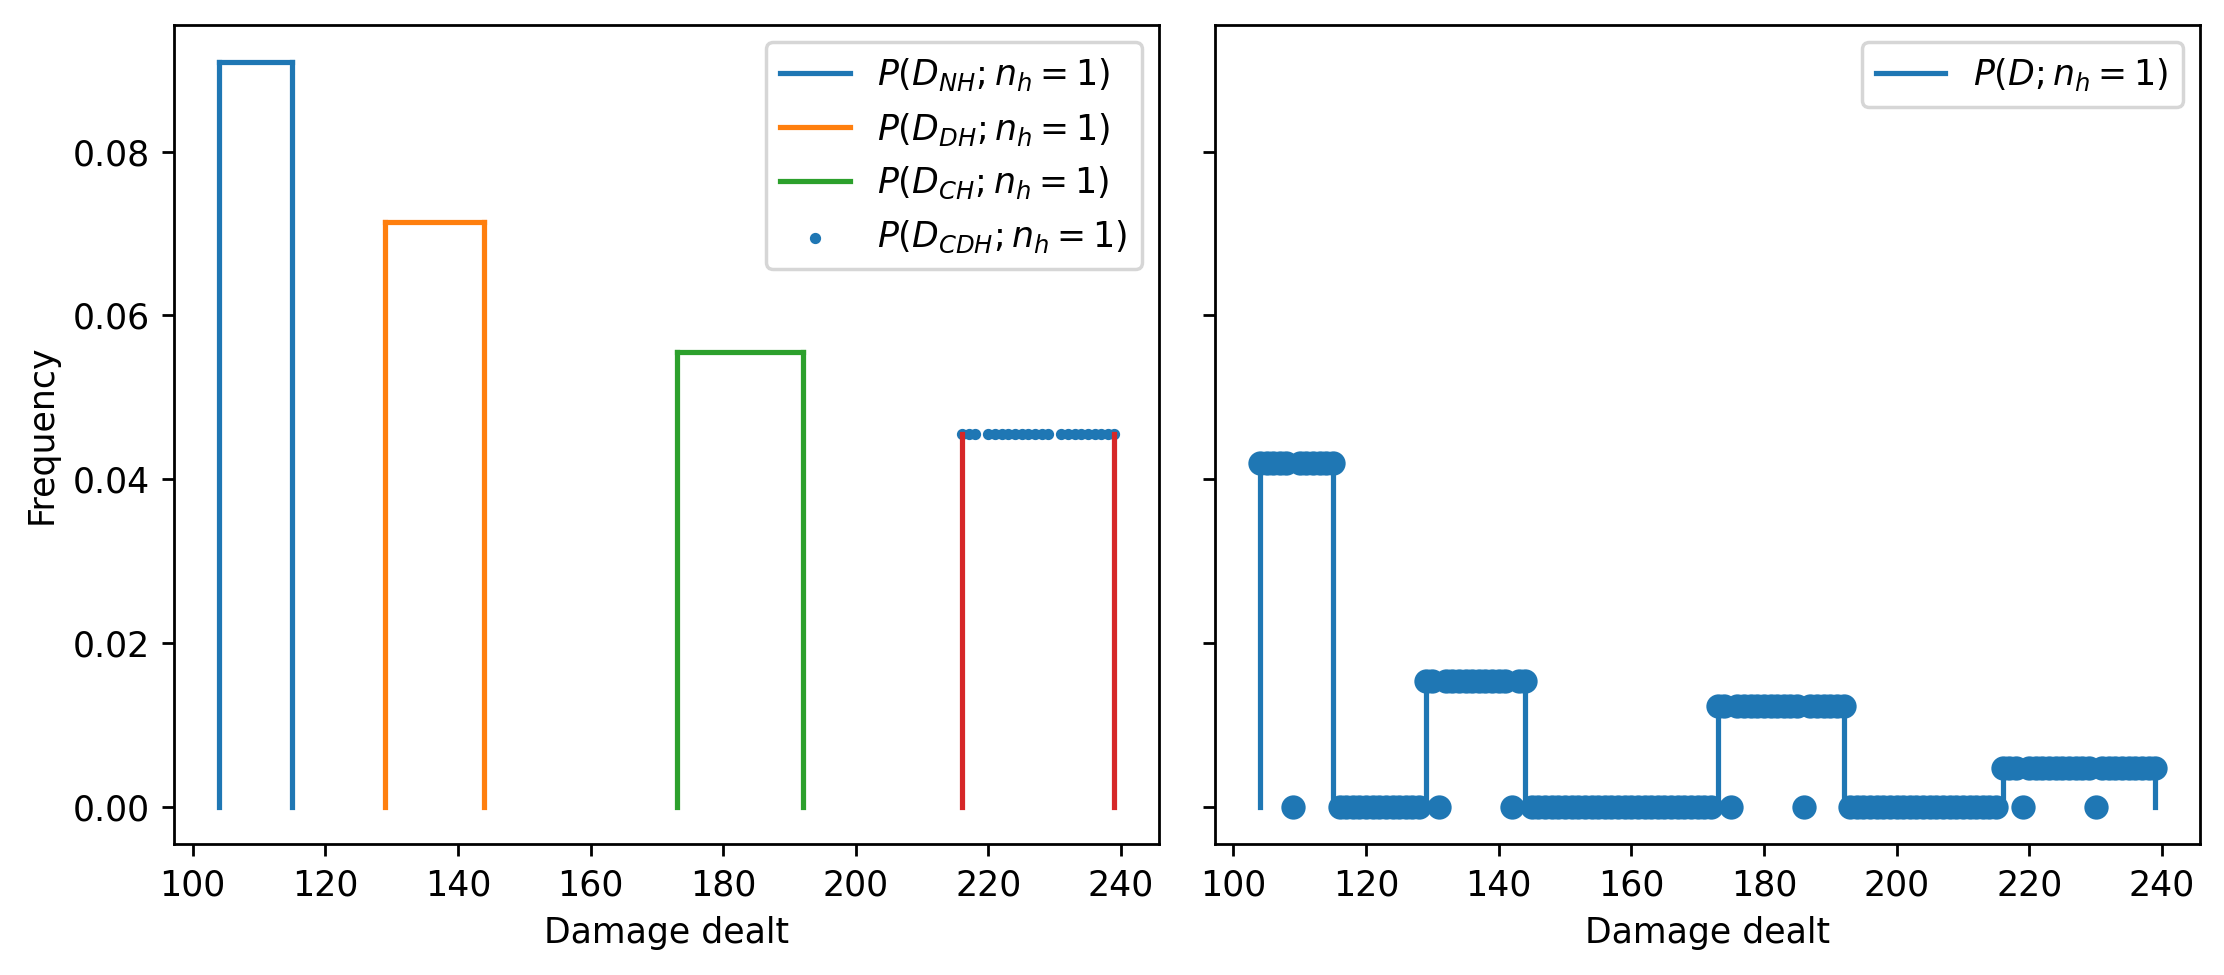

In [9]:
r = Rotation(rotation, 1)
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=250, sharey=True)

p = r.action_moments[0].p
nh = r.action_moments[0].normal_supp
dh = r.action_moments[0].dir_supp
ch = r.action_moments[0].crit_supp
cdh = r.action_moments[0].crit_dir_supp

ax[0].plot(nh, np.ones(nh.size) * 1/nh.size, label='$P(D_{NH};n_h=1)$')
ax[0].plot([nh[0], nh[0]], [0, 1/nh.size], color='C0')
ax[0].plot([nh[-1], nh[-1]], [0, 1/nh.size], color='C0')

ax[0].plot(dh, np.ones(dh.size) * 1/dh.size, label='$P(D_{DH};n_h=1)$')
ax[0].plot([dh[0], dh[0]], [0, 1/dh.size], color='C1')
ax[0].plot([dh[-1], dh[-1]], [0, 1/dh.size], color='C1')

ax[0].plot(ch, np.ones(ch.size) * 1/ch.size, label='$P(D_{CH};n_h=1)$')
ax[0].plot([ch[0], ch[0]], [0, 1/ch.size], color='C2')
ax[0].plot([ch[-1], ch[-1]], [0, 1/ch.size], color='C2')

ax[0].scatter(cdh, np.ones(cdh.size) * 1/cdh.size, s=5, label='$P(D_{CDH};n_h=1)$')
ax[0].plot([cdh[0], cdh[0]], [0, 1/cdh.size], color='C3')
ax[0].plot([cdh[-1], cdh[-1]], [0, 1/cdh.size], color='C3')

ax[1].plot(nh, np.ones(nh.size) * 1/nh.size * p[0], c='C0', label='$P(D;n_h=1)$')
ax[1].plot(dh, np.ones(dh.size) * 1/dh.size * p[2], c='C0')
ax[1].plot(ch, np.ones(ch.size) * 1/ch.size * p[1], c='C0')
ax[1].plot(cdh, np.ones(cdh.size) * 1/cdh.size * p[3], c='C0')
ax[1].scatter(np.arange(nh[0], cdh[-1] + 1), r.one_hit_pmf)
ax[1].plot([nh[0], nh[0]], [0, 1/nh.size * p[0]], color='C0')
ax[1].plot([nh[-1], nh[-1]], [0, 1/nh.size * p[0]], color='C0')
ax[1].plot([dh[0], dh[0]], [0, 1/dh.size * p[2]], color='C0')
ax[1].plot([dh[-1], dh[-1]], [0, 1/dh.size * p[2]], color='C0')
ax[1].plot([ch[0], ch[0]], [0, 1/ch.size * p[1]], color='C0')
ax[1].plot([ch[-1], ch[-1]], [0, 1/ch.size * p[1]], color='C0')
ax[1].plot([cdh[0], cdh[0]], [0, 1/cdh.size * p[3]], color='C0')
ax[1].plot([cdh[-1], cdh[-1]], [0, 1/cdh.size * p[3]], color='C0')


ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Damage dealt')
ax[1].set_xlabel('Damage dealt')
ax[0].set_ylabel('Frequency')
fig.tight_layout()

In [10]:

nvals = np.random.binomial(7, 0.5, size=100000)
potency = []
n_hits = []
a = Rate(1989, 436)

for n in nvals:
    x_vals1 = np.random.multinomial(n, a.p, size=1)
    n_hits.append(np.sum(x_vals1))
    potency.append(hits2pot(x_vals1, a.l_c, 125, 7500, buffs=[1.1])[0])

Text(0.5, 0, 'Damage dealt')

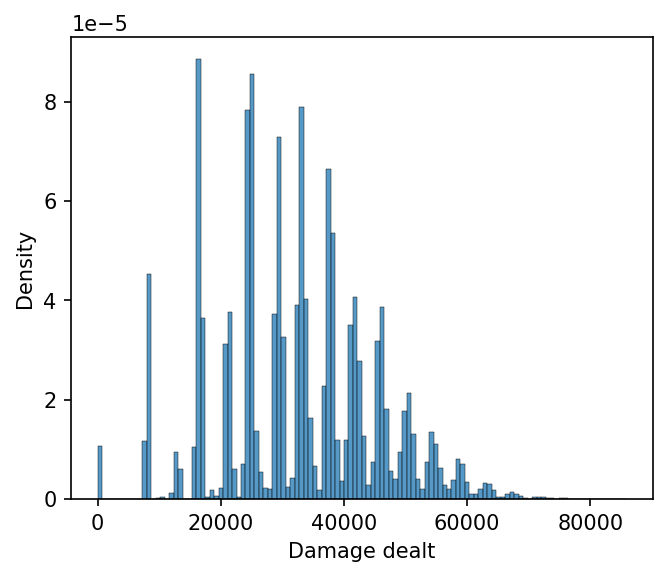

In [11]:
# sns.histplot(np.array(potency))
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)
sns.histplot(potency, stat='density')
ax.set_xlabel('Damage dealt')

[0.77517 0.21483 0.00783 0.00217] 1567.0


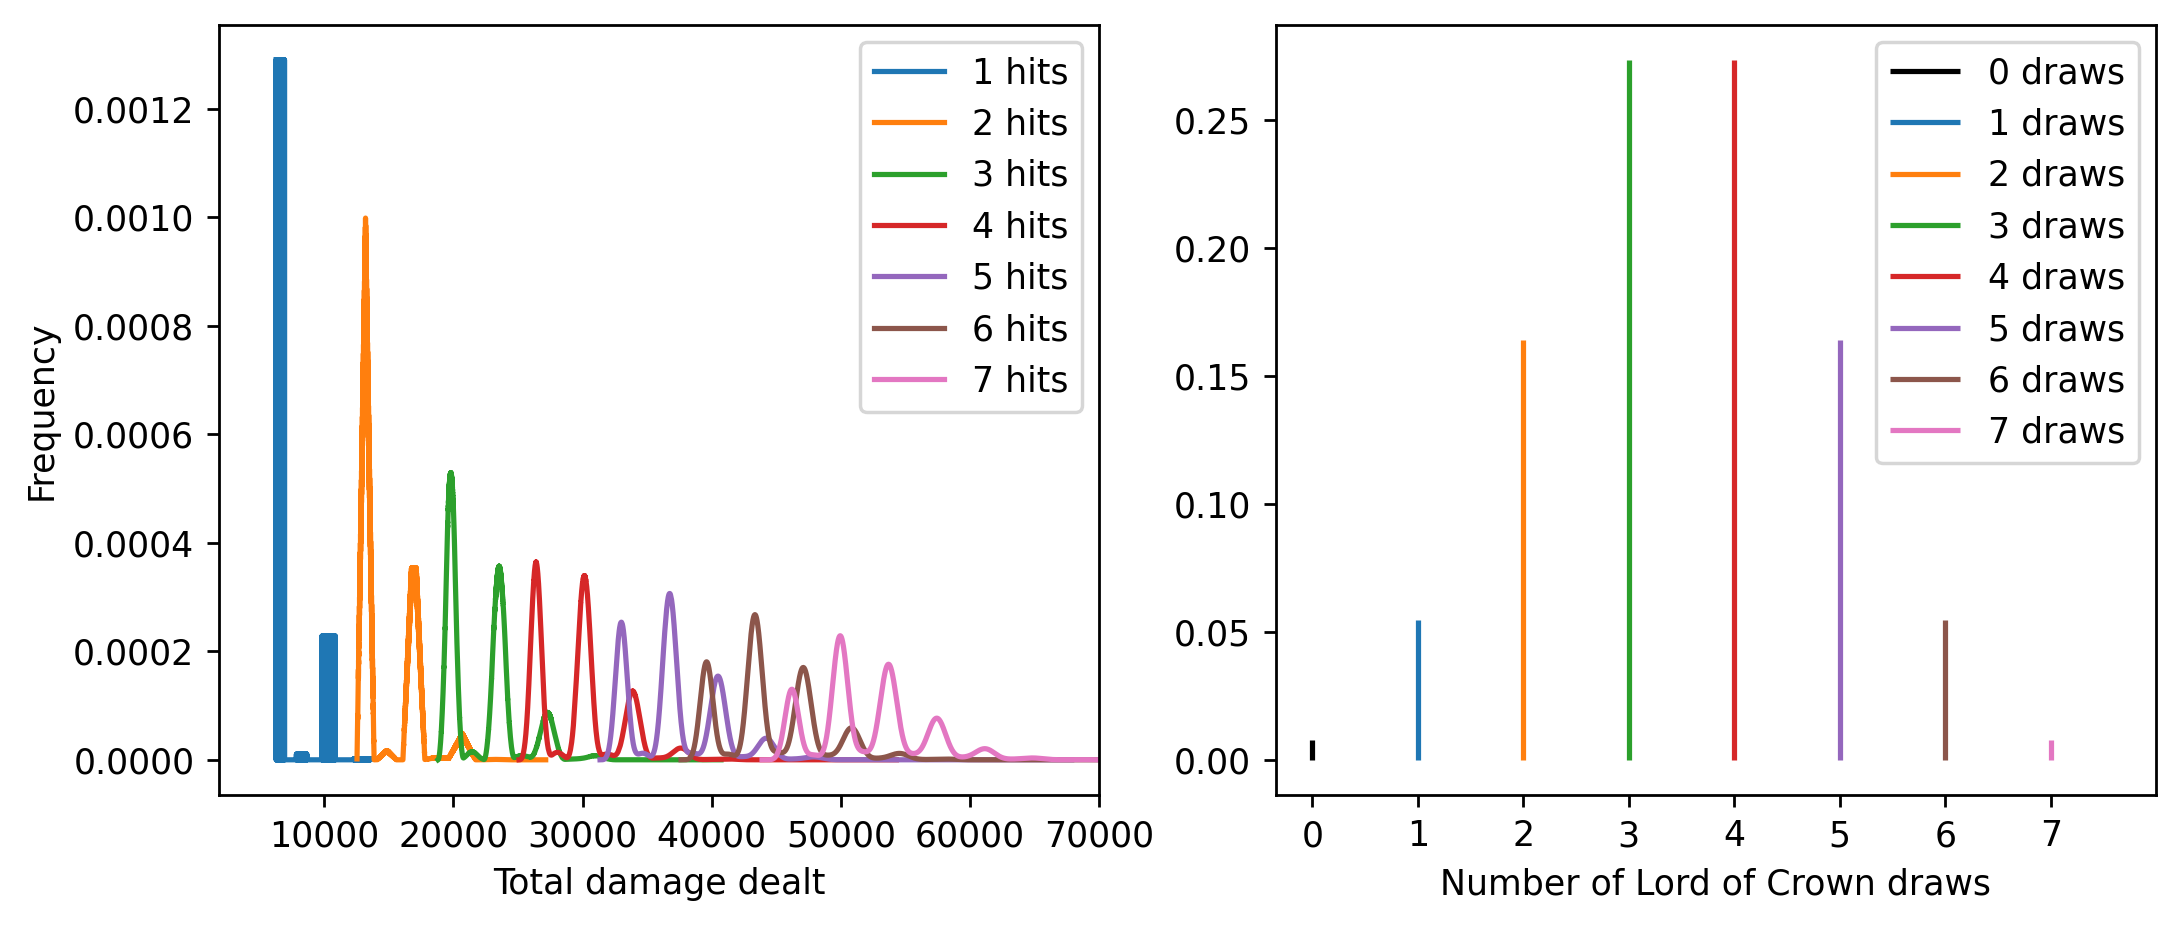

In [15]:
n_hits = 7
dps = []
p = []
a = Rate(1989, 436)

rotation = pd.DataFrame({
    'd2': [6000],
    'n': [7],
    'p': [a.p],
    'l_c': [a.l_c],
    'buffs': [[1.1]],
    'is-dot': [0],
    'action-name': ['test']})

t = 1
print(a.p, a.l_c)
fig, ax = plt.subplots(1, 2, figsize=(10,4), dpi=250)
binom_weights = binom(n_hits, 0.5).pmf(np.arange(n_hits+1)).reshape((n_hits+1,1))
ax[1].vlines(0, 0, binom_weights[0][0], color='k', label='0 draws')        

for n in np.arange(1, n_hits+1):
    rotation['n'].update(n)
    r = Rotation(rotation, t)

    a, b = r.convolve_pmf(0)
    dps.append(a)
    p.append(b)

    ax[0].plot(dps[n-1], p[n-1], label=f'{n} hits')
    
    ax[1].vlines(n, 0, binom_weights[n][0], color=f'C{n-1}', label=f'{n} draws')

    # if idx == 0:
    #     ax.vlines(idx, 0, b[0], color='k')
    # else:
ax[0].set_xlim([ax[0].get_xlim()[0], 70000])
ax[0].set_xlabel('Total damage dealt')
ax[1].set_xlabel('Number of Lord of Crown draws')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
ax[1].set_xlim([ax[1].get_xlim()[0], 8])
ax[1].set_xticks(np.arange(0,8))
plt.show()


In [16]:
big_grid = np.arange(0, max([np.max(d) for d in dps])+1)
h = np.zeros((n_hits+1, big_grid.size))
for a in range(1, n_hits+1):
    h[a, np.isin(big_grid, dps[a-1])] = p[a-1]
h[0, 0] = 1

t = (n_hits-1) * 60
binom_weights = binom(n_hits, 0.5).pmf(np.arange(n_hits+1)).reshape((n_hits+1,1))
p_total = np.sum(h * binom_weights, axis=0)

mu = np.dot(big_grid, p_total)
sigma = np.sqrt(np.dot(p_total, (big_grid - mu)**2)) / t

big_grid /= t
p_total *= t
p_total[0] = binom_weights[0][0]


In [17]:
rotation['n'].update(3)
r3 = rotation.copy()
r3
rotation['n'].update(4)
r4 = rotation.copy()
r4

,d2,n,p,l_c,buffs,is-dot,action-name
0,6000,4,"[0.77517, 0.21483, 0.00783, 0.00217]",1567.0,[1.1],0,test


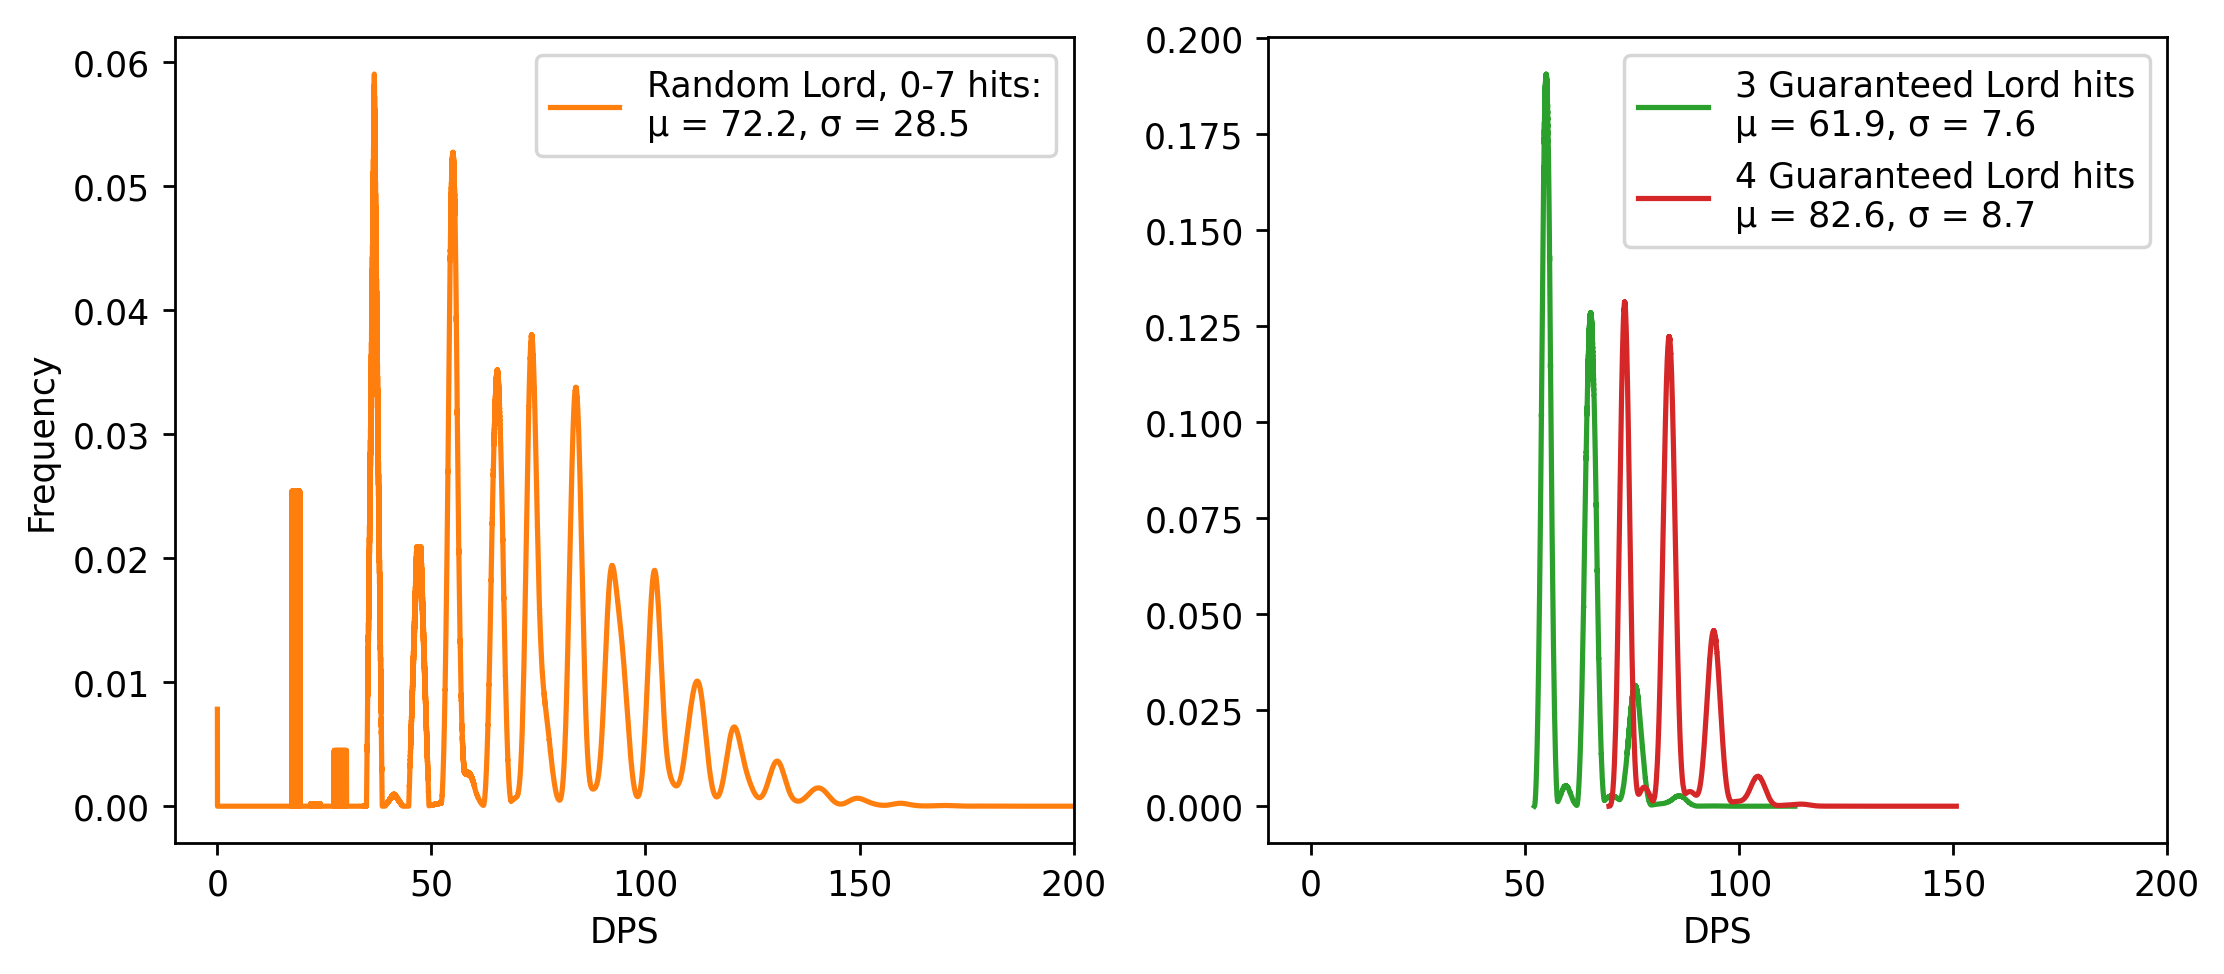

In [18]:


fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=250, sharex=True)


R3 = Rotation(r3, t)
x, y = R3.convolve_pmf(0)
ax[1].plot(x, y, c='C2', label=f"3 Guaranteed Lord hits\nμ = {R3.rotation_mean:2.1f}, σ = {R3.rotation_std:2.1f}")

R4 = Rotation(r4, t)
x, y = R4.convolve_pmf(0)
ax[1].plot(x, y, c='C3', label=f'4 Guaranteed Lord hits\nμ = {R4.rotation_mean:2.1f}, σ = {R4.rotation_std:2.1f}')



ax[0].plot(big_grid,p_total , c='C1', label=f"Random Lord, 0-7 hits:\nμ = {mu/t:2.1f}, σ = {sigma:2.1f}")
# ax[0].plot([0, 0], [0, binom_weights[0][0]], c='C1')
# sns.histplot(np.array(potency) / t, stat='density', ax=ax[0], 
#              alpha=0.4, label=f'Simulated results\n$N = 10^7$')

ax[0].set_xlabel('DPS')
ax[1].set_xlabel('DPS')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([-10, 200])
ax[1].set_xlim([-10, 200])
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

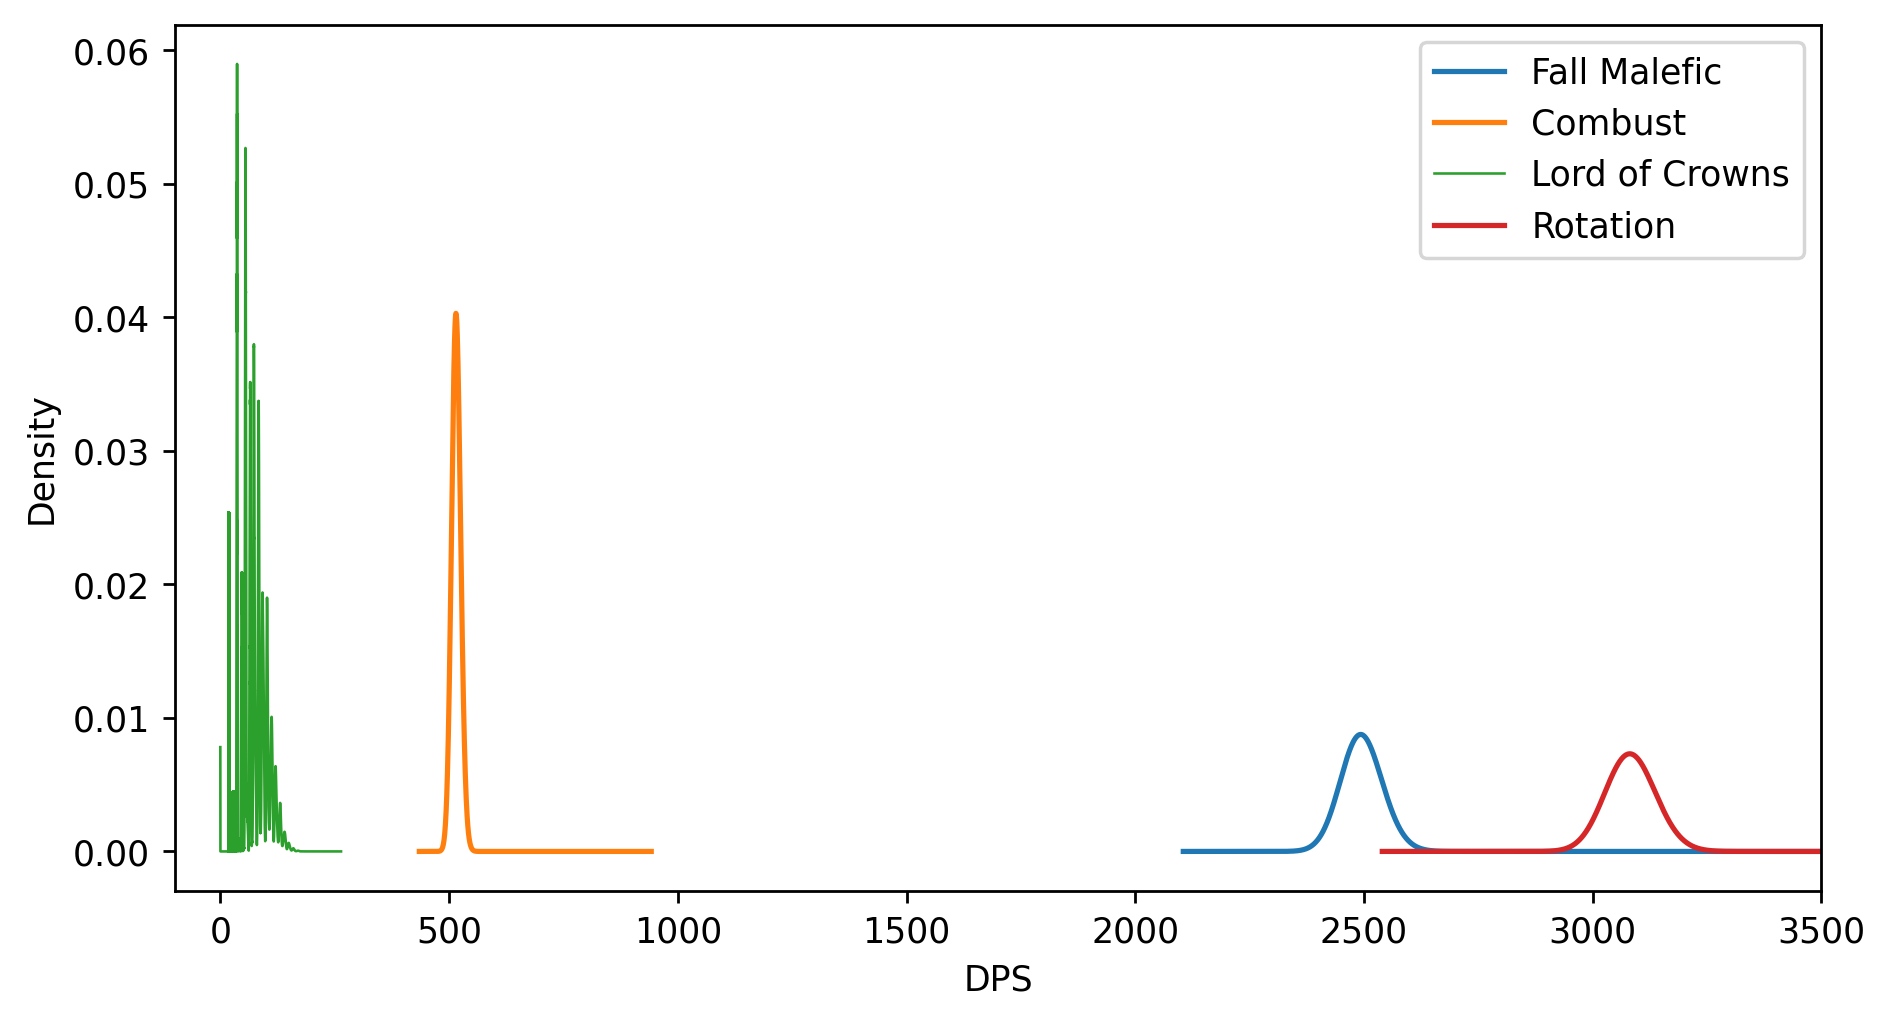

In [22]:
a = Rate(1989, 436)
t = (n_hits-1) * 60
full_rotation = pd.DataFrame({
    'd2': [6000, 1375],
    'n': [133, 120],
    'p': [a.p]*2,
    'l_c': [a.l_c]*2,
    'buffs': [None, None],
    'is-dot': [0, 1],
    'action-name': ['Fall Malefic', 'Combust']})

full_r = Rotation(full_rotation, t)

fig, ax = plt.subplots(1, 1, figsize=(8.5,4.5), dpi=250)
for x in range(2):
    ax.plot(full_r.action_dps_support[x], full_r.action_DPS_distributions[x], label=full_rotation['action-name'][x])
ax.plot(big_grid, p_total, label='Lord of Crowns', linewidth=0.75)


# ax.plot(full_r.rotation_dps_support, full_r.rotation_DPS_distribution, label='Rotation')

delta = 0.5
s_support = np.arange(0, int(big_grid[-1]) + delta, step=delta)
s_dps_dist = np.interp(s_support, big_grid, p_total)
rotation_supp = np.arange(s_support[0] + full_r.rotation_dps_support[0], full_r.rotation_dps_support[-1] + s_support[-1] + delta, step=delta)

ax.plot(rotation_supp, fftconvolve(s_dps_dist, full_r.rotation_DPS_distribution)*delta, label='Rotation')

ax.legend()
ax.set_xlabel('DPS')
ax.set_ylabel('Density')
ax.set_xlim([-100, 3500])
# print(np.trapz(full_r.rotation_DPS_distribution, full_r.rotation_dps_support),
#       np.trapz(fftconvolve(s_dps_dist, full_r.rotation_DPS_distribution)*delta, rotation_supp))
plt.show



2.012630417524291


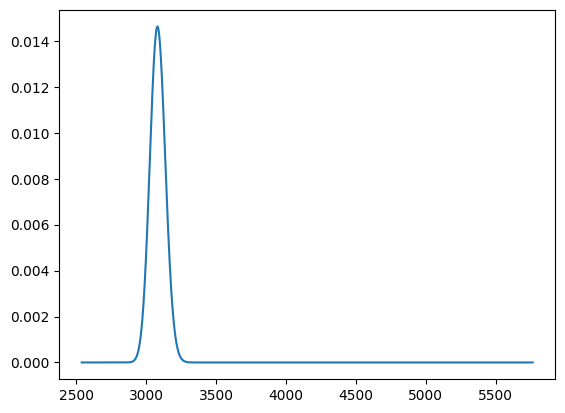

In [23]:


delta = 0.5
s_support = np.arange(0, int(big_grid[-1]) + delta, step=delta)
s_dps_dist = np.interp(s_support, big_grid, p_total)
rotation_supp = np.arange(s_support[0] + full_r.rotation_dps_support[0], full_r.rotation_dps_support[-1] + s_support[-1] + delta, step=delta)
print(np.trapz(fftconvolve(s_dps_dist, full_r.rotation_DPS_distribution), rotation_supp))
plt.plot(rotation_supp, fftconvolve(s_dps_dist, full_r.rotation_DPS_distribution))

In [24]:
print(f"Guaranteed lord\n3 hits: μ = {R3.rotation_mean:2.1f}, σ = {R3.rotation_std:2.1f}")
print(f"Guaranteed lord, 4 hits: μ = {R4.rotation_mean:2.1f} (DPS), σ = {R4.rotation_std:2.1f}  (DPS)")

mu = np.dot(big_grid, p_total)
sigma = np.sqrt(np.dot(p_total, (big_grid - mu)**2)) / t

print(f"50% lord, 0 - 7 hits:    μ = {mu/t:2.1f} (DPS), σ = {sigma:2.1f} (DPS)")


Guaranteed lord
3 hits: μ = 61.9, σ = 7.6
Guaranteed lord, 4 hits: μ = 82.6 (DPS), σ = 8.7  (DPS)
50% lord, 0 - 7 hits:    μ = 72.2 (DPS), σ = 1361.4 (DPS)


In [25]:
mu = np.dot(big_grid, p_total)

mu/t, np.sqrt(np.dot(p_total, (big_grid - mu)**2)) / t

(72.2362833355037, 1361.416369454667)

## Random rotations

In [27]:
from itertools import product

In [30]:
def sequence_enumerate(iterable):
    a = Rate(1989, 436)
    w = np.array([0.005, 0.435, 0.560])
    dmg = []
    p = []
    path_prob = []
    t = 1
    for x in iterable:
    # for x in [(2,2,2,2,2), (3,3,3,3,3)]:
        path_prob.append(np.prod(w[np.array(x)-1]))
        print(x, w[np.array(x)-1], path_prob[-1])

        n_1_seal = np.count_nonzero(np.array(x) == 1)
        n_2_seal = np.count_nonzero(np.array(x) == 2)
        n_3_seal = np.count_nonzero(np.array(x) == 3)

        buffed_hits = 10 * n_3_seal
        base_hits = (28*4 + 4) + 8*n_1_seal + 10*n_2_seal

        rotation = pd.DataFrame({
            'd2': [5000, 5000],
            'n': [base_hits, buffed_hits],
            'p': [a.p, a.p],
            'l_c': [a.l_c, a.l_c],
            'buffs': [None, [1.05]],
            'is-dot': [0, 0],
            'action-name': ['Fall Malefic', 'Buff Fall Malefic']})
        rotation = rotation[rotation.n != 0]
        # display(rotation)
        r = Rotation(rotation, t)

        alpha, omega, squigma = r.moments_to_skew_norm(r.rotation_mean, r.rotation_mean, r.rotation_skewness)
        # x = np.linspace(r.rotation_mean - 5 * r.rotation_std, r.rotation_mean + 5 * r.rotation_std, 500)
        x = np.arange(np.floor(r.rotation_mean - 5 * r.rotation_std), 
                    np.floor(r.rotation_mean + 5 * r.rotation_std))
        y = skewnorm.pdf(x, alpha, squigma, omega)
        # print(base_hits, buffed_hits, r.rotation_mean / 390)

        dmg.append(x)
        p.append(y)
    return dmg, p, np.array(path_prob)

In [33]:
a = Rate(1989, 436)
dmg, p, path_prob = sequence_enumerate(product((1, 2, 3), repeat=5))

(1, 1, 1, 1, 1) [0.005 0.005 0.005 0.005 0.005] 3.1250000000000005e-12
(1, 1, 1, 1, 2) [0.005 0.005 0.005 0.005 0.435] 2.7187500000000006e-10
(1, 1, 1, 1, 3) [0.005 0.005 0.005 0.005 0.56 ] 3.500000000000001e-10
(1, 1, 1, 2, 1) [0.005 0.005 0.005 0.435 0.005] 2.7187500000000006e-10
(1, 1, 1, 2, 2) [0.005 0.005 0.005 0.435 0.435] 2.3653125000000004e-08
(1, 1, 1, 2, 3) [0.005 0.005 0.005 0.435 0.56 ] 3.0450000000000005e-08
(1, 1, 1, 3, 1) [0.005 0.005 0.005 0.56  0.005] 3.500000000000001e-10
(1, 1, 1, 3, 2) [0.005 0.005 0.005 0.56  0.435] 3.0450000000000005e-08
(1, 1, 1, 3, 3) [0.005 0.005 0.005 0.56  0.56 ] 3.9200000000000014e-08
(1, 1, 2, 1, 1) [0.005 0.005 0.435 0.005 0.005] 2.71875e-10
(1, 1, 2, 1, 2) [0.005 0.005 0.435 0.005 0.435] 2.3653125e-08
(1, 1, 2, 1, 3) [0.005 0.005 0.435 0.005 0.56 ] 3.0450000000000005e-08
(1, 1, 2, 2, 1) [0.005 0.005 0.435 0.435 0.005] 2.3653125e-08
(1, 1, 2, 2, 2) [0.005 0.005 0.435 0.435 0.435] 2.057821875e-06
(1, 1, 2, 2, 3) [0.005 0.005 0.435 0.435 0.5

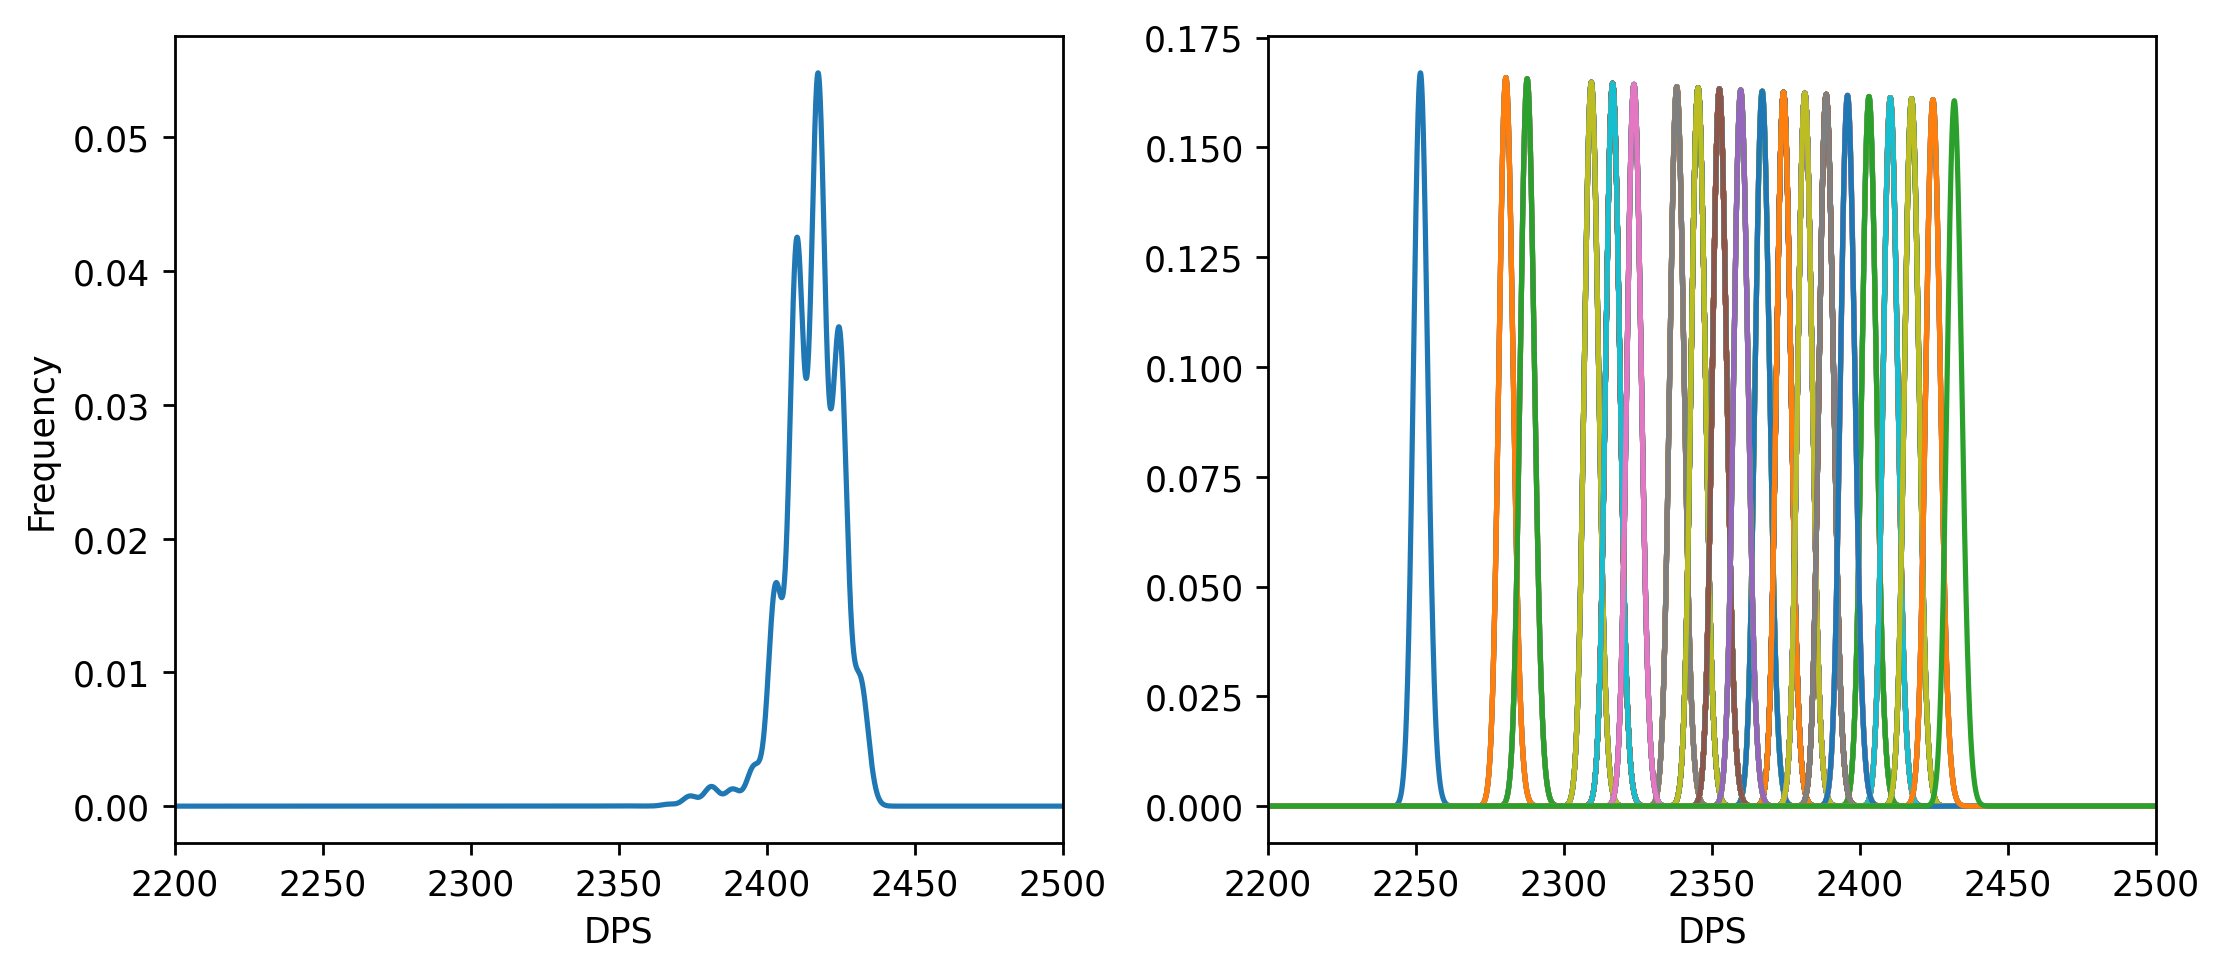

In [34]:
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=250)
n_hits = len(path_prob)
big_grid = np.arange(min([np.min(d) for d in dmg]), max([np.max(d) for d in dmg])+1)
h = np.zeros((n_hits, big_grid.size))
for a in range(n_hits):
    h[a, np.isin(big_grid, dmg[a])] = p[a]
    ax[1].plot(big_grid / 390, h[a] * 390)

ax[0].set_xlim([2200, 2500])
ax[1].set_xlim([2200, 2500])
ax[1].set_xlabel('DPS')
ax[0].set_xlabel('DPS')
ax[0].set_ylabel('Frequency')


path_prob = np.array(path_prob).reshape((len(path_prob),1))
p_total = np.sum(h * path_prob, axis=0)
ax[0].plot(big_grid / 390, p_total * 390)
plt.tight_layout()
plt.show()

In [31]:
hits, counts = np.unique(np.sort(np.array(list(product((1, 2, 3), repeat=5))), axis=1), axis=0, return_counts=True)
dmg, p, path_prob = sequence_enumerate(hits)


[1 1 1 1 1] [0.005 0.005 0.005 0.005 0.005] 3.1250000000000005e-12
[1 1 1 1 2] [0.005 0.005 0.005 0.005 0.435] 2.7187500000000006e-10
[1 1 1 1 3] [0.005 0.005 0.005 0.005 0.56 ] 3.500000000000001e-10
[1 1 1 2 2] [0.005 0.005 0.005 0.435 0.435] 2.3653125000000004e-08
[1 1 1 2 3] [0.005 0.005 0.005 0.435 0.56 ] 3.0450000000000005e-08
[1 1 1 3 3] [0.005 0.005 0.005 0.56  0.56 ] 3.9200000000000014e-08
[1 1 2 2 2] [0.005 0.005 0.435 0.435 0.435] 2.057821875e-06
[1 1 2 2 3] [0.005 0.005 0.435 0.435 0.56 ] 2.6491500000000003e-06
[1 1 2 3 3] [0.005 0.005 0.435 0.56  0.56 ] 3.410400000000001e-06
[1 1 3 3 3] [0.005 0.005 0.56  0.56  0.56 ] 4.390400000000001e-06
[1 2 2 2 2] [0.005 0.435 0.435 0.435 0.435] 0.000179030503125
[1 2 2 2 3] [0.005 0.435 0.435 0.435 0.56 ] 0.00023047605
[1 2 2 3 3] [0.005 0.435 0.435 0.56  0.56 ] 0.0002967048
[1 2 3 3 3] [0.005 0.435 0.56  0.56  0.56 ] 0.00038196480000000015
[1 3 3 3 3] [0.005 0.56  0.56  0.56  0.56 ] 0.0004917248000000002
[2 2 2 2 2] [0.435 0.435 0.435

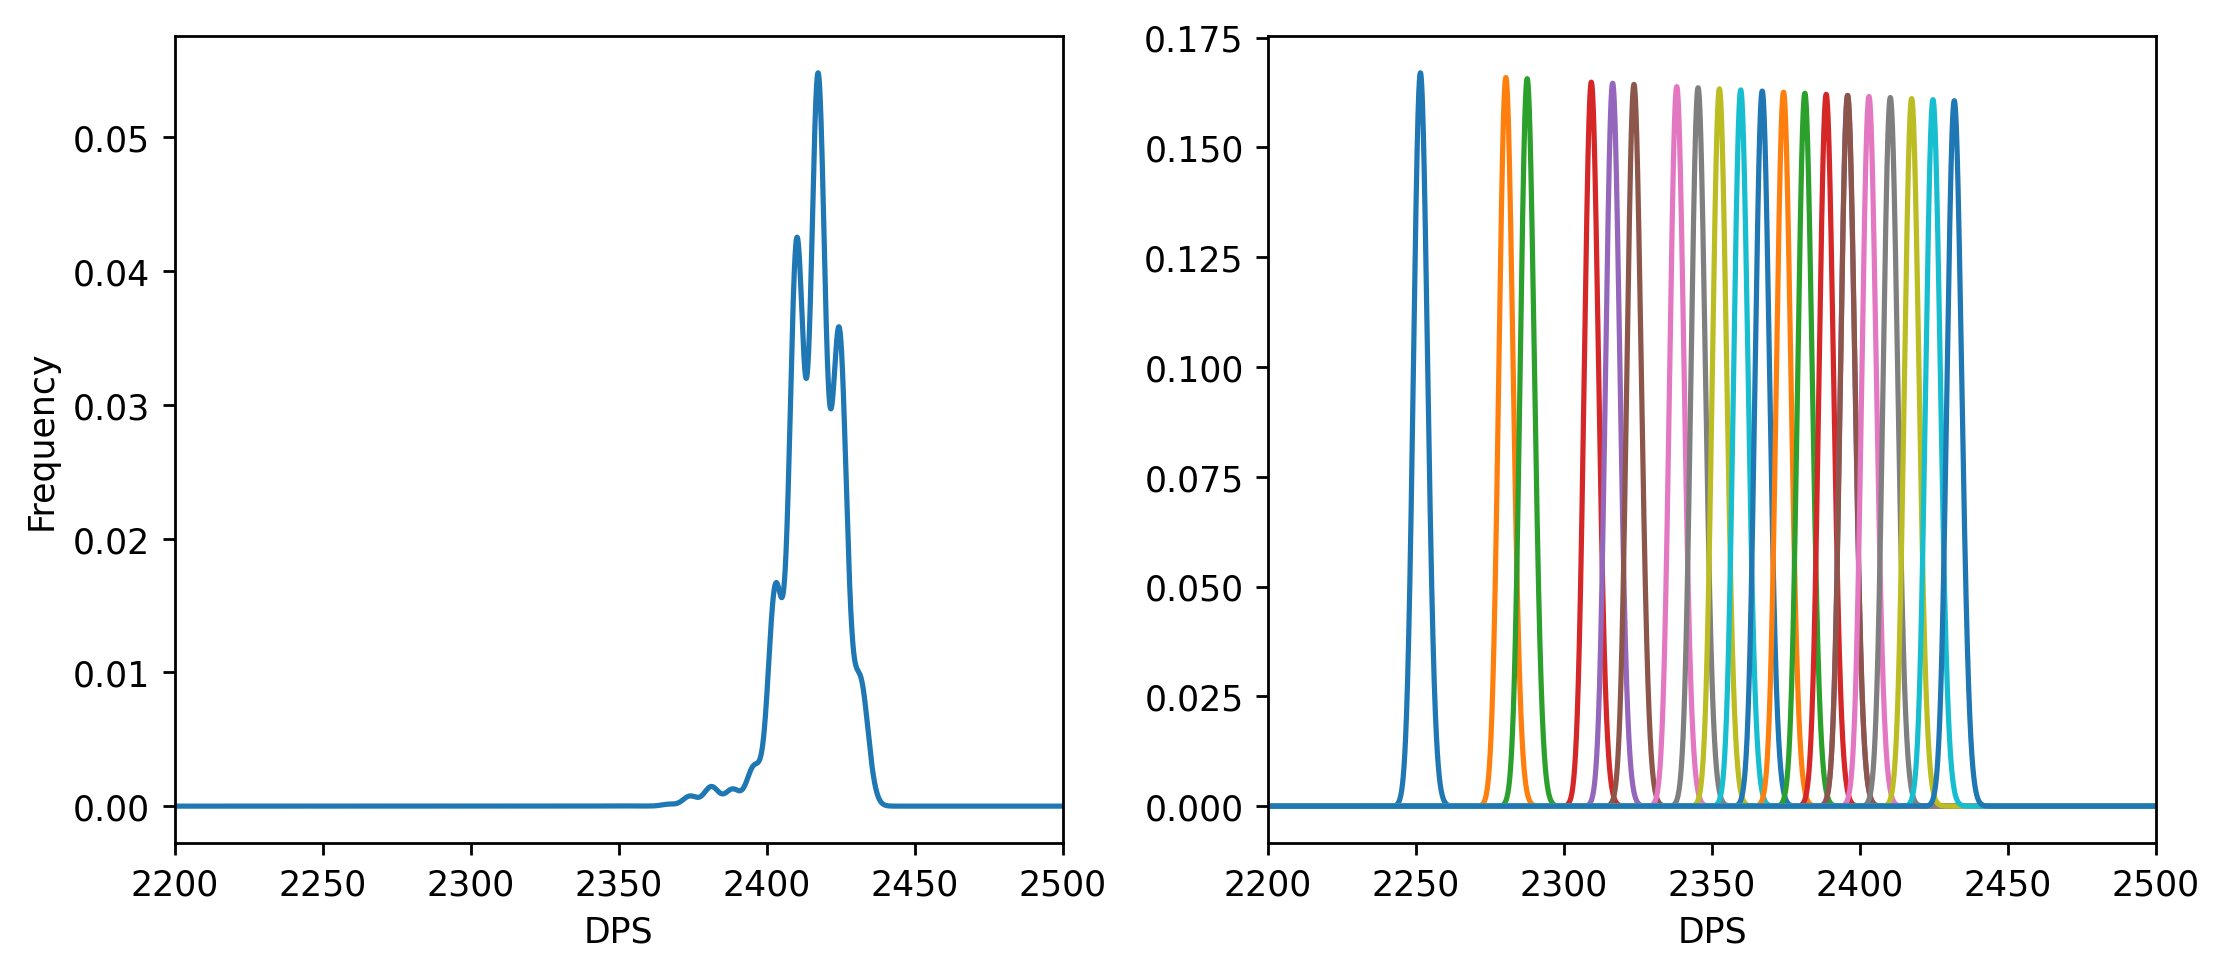

In [32]:
fig, ax = plt.subplots(1,2, figsize=(9,4), dpi=250)
n_hits = len(path_prob)
big_grid = np.arange(min([np.min(d) for d in dmg]), max([np.max(d) for d in dmg])+1)
h = np.zeros((n_hits, big_grid.size))
for a in range(n_hits):
    h[a, np.isin(big_grid, dmg[a])] = p[a]
    ax[1].plot(big_grid / 390, h[a] * 390)

ax[1].set_xlim([2200, 2500])
ax[0].set_xlim([2200, 2500])
ax[0].set_xlabel('DPS')
ax[1].set_xlabel('DPS')
ax[0].set_ylabel('Frequency')


# path_prob = np.array(path_prob).reshape((len(path_prob),1))
w_path_prob = (np.array(path_prob).ravel()*counts).reshape((len(path_prob),1))
p_total = np.sum(h * w_path_prob, axis=0)
culled_p_total = np.sum(h[8:] * w_path_prob[8:], axis=0)
ax[0].plot(big_grid / 390, p_total * 390)
# p_total = np.sum(h * w_path_prob, axis=0)
# ax[0].plot(big_grid / 390, culled_p_total * 390, color='C1', linestyle='--')
plt.tight_layout()
plt.show()

0.00041191492078564195